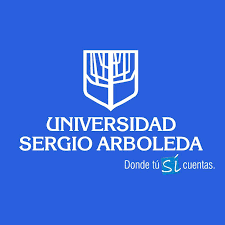

###***Integrantes:***

* Santiago Niño
* Esteban Rodriguez
* Daniel Velasquez
* Laura Ojeda

###***Ejercicio***

* Simular un S.M.A. que solucione un problema particular (El grupo define el problema. Más de 50 agentes)
Medir la entropía del sistema. (video sobre entropia)
Diseñar el control del sistema y medir la entropía.
Hacer la comparación entre los dos sistemas, el sistema sin control y el sistema con control
___
* Nota: La implementación debe estar en Python (Usar M.B.A. Se recomienda usar el framework MESA)

###***Contexto***

**La** **gestión de epidemias y enfermedades infecciosas**, la simulación de sistemas multiagente (SMA) se ha convertido en una herramienta invaluable para comprender la propagación de enfermedades y evaluar la eficacia de diversas estrategias de control.

Este estudio se centra en la simulación de una epidemia en una población mediante un SMA, donde cada agente representa un individuo y sus interacciones modelan la transmisión de la enfermedad. Específicamente, exploramos el impacto de medidas de control como la vacunación en la dinámica de la enfermedad y en la entropía del sistema, un indicador clave de su complejidad y organización.


A través de la comparación entre un sistema con control (vacunación) y otro sin control, buscamos identificar cómo estas medidas afectan la propagación de la enfermedad y la estabilidad del sistema de salud.

----

###***Desarrollo:***

In [ ]:
!pip install mesa

In [ ]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from collections import Counter
import random
from scipy.stats import entropy
import matplotlib.pyplot as plt

In [ ]:
class Persona(Agent):
    def __init__(self, unique_id, model, vacunado=False):
        super().__init__(unique_id, model)
        self.salud = "susceptible"
        self.dias_infectado = 0
        self.vacunado = vacunado

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def contactos_sociales(self):
        neighbors = self.model.grid.get_neighbors(self.pos, moore=True)
        for neighbor in neighbors:
            if self.salud == "infectado" and neighbor.salud == "susceptible":
                if random.random() < 0.45:  # Probabilidad de infección
                    if not neighbor.vacunado:  # Verificar si el vecino no está vacunado
                        neighbor.salud = "infectado"

    def step(self):
        if self.salud == "infectado":
            self.dias_infectado += 1
            if self.dias_infectado >= 25:  # Duración de la infección
                self.salud = "recuperado"
        else:
            self.move()
            self.contactos_sociales()

In [ ]:
class EpidemiaModel(Model):
    def __init__(self, N, width, height, tasa_vacunacion=None):
        super().__init__()
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.running = True

        # Crear agentes
        for i in range(self.num_agents):
            if tasa_vacunacion is not None and random.random() < tasa_vacunacion:
                a = Persona(i, self, vacunado=True)
            else:
                a = Persona(i, self)
            self.schedule.add(a)

            # Agregar agentes a una celda de la cuadrícula aleatoria
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

            # Infectar aleatoriamente algunos agentes al principio
            if random.random() < 0.1:  # Tasa inicial de infección
                a.salud = "infectado"

        self.datacollector = DataCollector(
            agent_reporters={"Salud": "salud"}
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

    def calcular_entropia(self):
        agentes = self.datacollector.get_agent_vars_dataframe()
        estado_salud = agentes["Salud"].fillna("susceptible")  # Rellenar NaN con "susceptible"

        # Calcular la distribución de salud actualizando con Counter
        distribucion_salud = Counter(estado_salud.values.flatten())

        # Calcular la probabilidad de cada estado de salud
        total_agentes = sum(distribucion_salud.values())
        probabilidades = [count / total_agentes for count in distribucion_salud.values()]

        # Calcular la entropía de Shannon
        entropia = entropy(probabilidades, base=2)
        return entropia

In [ ]:
# Función para ejecutar el modelo y recopilar datos
def ejecutar_modelo(modelo, pasos):
    estados_salud = {"susceptible": [], "infectado": [], "recuperado": []}

    for _ in range(pasos):
        modelo.step()
        agentes = modelo.datacollector.get_agent_vars_dataframe()
        estado_salud = agentes["Salud"].fillna("susceptible")
        distribucion_salud = estado_salud.value_counts(normalize=True)
        for estado in estados_salud.keys():
            if estado in distribucion_salud:
                estados_salud[estado].append(distribucion_salud[estado])
            else:
                estados_salud[estado].append(0)

    return estados_salud

# Función para graficar los datos recopilados
def graficar_datos(datos, titulo):
    pasos = range(len(datos["susceptible"]))
    plt.figure(figsize=(10, 6))
    plt.plot(pasos, datos["susceptible"], label="Susceptible", color="blue")
    plt.plot(pasos, datos["infectado"], label="Infectado", color="red")
    plt.plot(pasos, datos["recuperado"], label="Recuperado", color="green")
    plt.xlabel("Pasos de tiempo")
    plt.ylabel("Proporción de agentes")
    plt.title(titulo)
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# Configuración del modelo
N = 100  # Número de agentes
width = 10  # Ancho de la cuadrícula
height = 10  # Altura de la cuadrícula

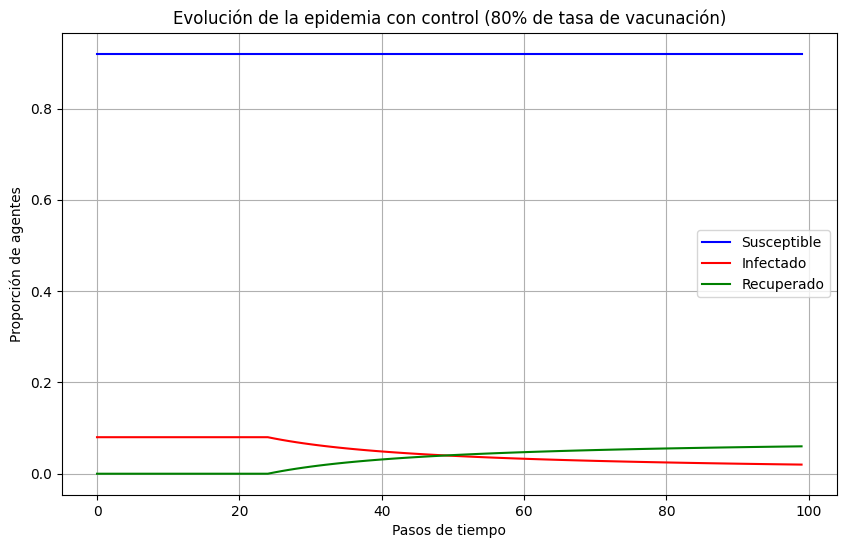

In [ ]:
# Creación del modelo con control (tasa de vacunación del 50%)
modelo_con_control = EpidemiaModel(N, width, height, tasa_vacunacion=0.8)
datos_con_control = ejecutar_modelo(modelo_con_control, 100)

# Gráfico con control
graficar_datos(datos_con_control, "Evolución de la epidemia con control (80% de tasa de vacunación)")

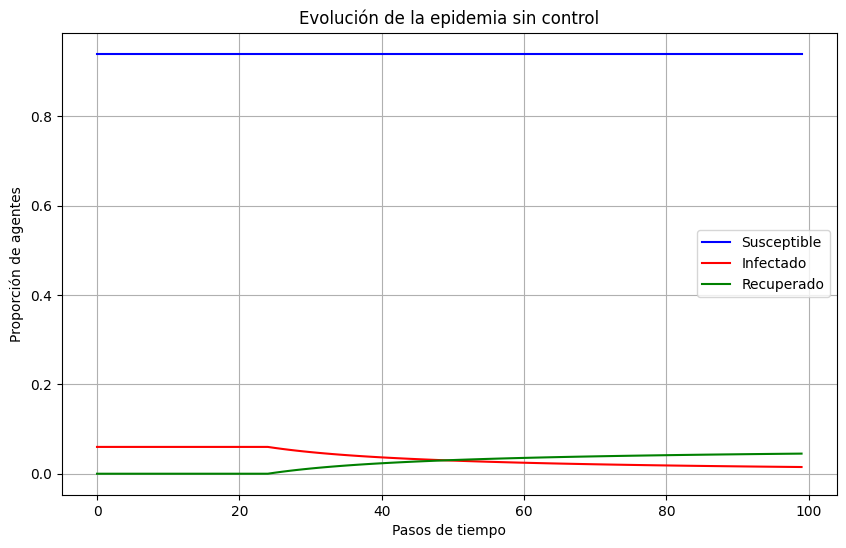

In [ ]:
# Creación del modelo sin control
modelo_sin_control = EpidemiaModel(N, width, height)
datos_sin_control = ejecutar_modelo(modelo_sin_control, 100)

# Gráfico sin control
graficar_datos(datos_sin_control, "Evolución de la epidemia sin control")

***Explicación***

* La gráfica representa la evolución de la epidemia a lo largo del tiempo en función del estado de salud de los agentes en la población simulada. Aquí tienes una explicación detallada de cada parte de la gráfica:

  * Eje X (Días): Este eje muestra el progreso de la simulación en términos de días. Cada punto en la gráfica corresponde a un paso de tiempo en la simulación, donde un paso de tiempo puede representar un día en el contexto de la epidemia.

  * Eje Y (Cantidad de personas): Este eje muestra la cantidad de personas en la población que tienen un estado de salud particular en un momento dado. La cantidad total de personas se divide en tres categorías según su estado de salud: "Susceptible", "Infectado" y "Recuperado".

* Líneas de la gráfica:

  * "Susceptible": Esta línea muestra la cantidad de personas que aún no han sido infectadas y que son susceptibles a contraer la enfermedad. Inicialmente, toda la población cae en esta categoría, y con el tiempo, a medida que la enfermedad se propaga, esta cantidad disminuirá.
  ___
  * "Infectado": Esta línea muestra la cantidad de personas que están actualmente infectadas con la enfermedad. Esta cantidad aumentará inicialmente a medida que la enfermedad se propaga, alcanzará un pico y luego disminuirá a medida que algunas personas se recuperen.
  ___
  * "Recuperado": Esta línea muestra la cantidad de personas que se han recuperado de la enfermedad y ahora son inmunes a la reinfección. Esta cantidad aumentará con el tiempo a medida que las personas se recuperen de la enfermedad.
  ___
  * Leyenda (Estado de salud): Esta leyenda muestra la correspondencia entre los colores de las líneas y los estados de salud representados en la gráfica: "Susceptible", "Infectado" y "Recuperado".

* La gráfica te permite visualizar cómo evoluciona la epidemia en la población simulada a lo largo del tiempo, mostrando cuántas personas están en cada estado de salud en cada paso de la simulación. Esto te ayuda a comprender mejor la dinámica de la propagación de la enfermedad y cómo afecta a la población en general.

## Calculo Entropia

In [ ]:
# Configuración de la simulación
num_agentes = 50
tamano_mundo = 10
num_pasos_simulacion = 20
tasa_vacunacion = 0.9  # Tasa de vacunación

In [ ]:
entropia_con_control = []
entropia_sin_control = []

for _ in range(num_pasos_simulacion):
  # Sistema Con Control (Vacunación) con cálculo de entropía
  modelo_con_control = EpidemiaModel(num_agentes, tamano_mundo, tamano_mundo, tasa_vacunacion)

  # Simulación y cálculo de entropía con control

  modelo_con_control.step()
  entropia = modelo_con_control.calcular_entropia()
  entropia_con_control.append(entropia)


for _ in range(num_pasos_simulacion):
  # Sistema Sin Control (Sin Vacunación) con cálculo de entropía
  modelo_sin_control = EpidemiaModel(num_agentes, tamano_mundo, tamano_mundo, None)

  # Simulación y cálculo de entropía sin control
  modelo_sin_control.step()
  entropia = modelo_sin_control.calcular_entropia()
  entropia_sin_control.append(entropia)

In [ ]:
# Imprimir valores de entropía
print("Entropía con control (vacunación):", entropia_con_control)
print("Entropía sin control (sin vacunación):", entropia_sin_control)

Entropía con control (vacunación): [0.5293608652873644, 0.584238811642856, 0.46899559358928117, 0.46899559358928117, 0.4021791902022729, 0.24229218908241482, 0.46899559358928117, 0.3274449191544763, 0.3274449191544763, 0.3274449191544763, 0.46899559358928117, 0.4021791902022729, 0.24229218908241482, 0.584238811642856, 0.14144054254182067, 0.3274449191544763, 0.3274449191544763, 0.5293608652873644, 0.3274449191544763, 0.3274449191544763]
Entropía sin control (sin vacunación): [0.24229218908241482, 0.7219280948873623, 0.6343095546405662, 0.5293608652873644, 0.46899559358928117, 0.584238811642856, 0.5293608652873644, 0.5293608652873644, 0.5293608652873644, 0.5293608652873644, 0.584238811642856, 0.3274449191544763, 0.5293608652873644, 0.46899559358928117, 0.584238811642856, 0.3274449191544763, 0.584238811642856, 0.584238811642856, 0.14144054254182067, 0.584238811642856]


In [ ]:
# Imprimir promedios
print("Promedio de Entropía con control (vacunación):", sum(entropia_con_control) / len(entropia_con_control))
print("Promedio de Entropía sin control (sin vacunación):", sum(entropia_sin_control) / len(entropia_sin_control))

Promedio de Entropía con control (vacunación): 0.39128397317050473
Promedio de Entropía sin control (sin vacunación): 0.5007224734110498


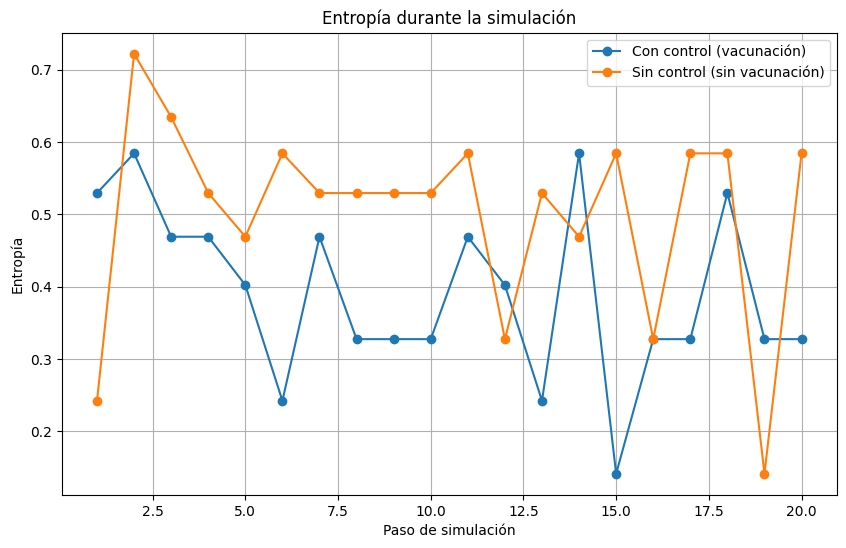

In [ ]:
# Crear gráfico
plt.figure(figsize=(10, 6))

# Plot de entropía con control
plt.plot(range(1, num_pasos_simulacion + 1), entropia_con_control, label='Con control (vacunación)', marker='o')

# Plot de entropía sin control
plt.plot(range(1, num_pasos_simulacion + 1), entropia_sin_control, label='Sin control (sin vacunación)', marker='o')

# Configurar el gráfico
plt.title('Entropía durante la simulación')
plt.xlabel('Paso de simulación')
plt.ylabel('Entropía')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()

Basándonos en la simulación de interacción de agentes y considerando una población de 50 individuos con una tasa de vacunación del 90%, podemos observar que los niveles de entropía en promedio son significativamente menores en el sistema con vacunación en comparación con el sistema sin vacunación.

La entropía en este contexto puede interpretarse como una medida de la incertidumbre o desorden en el sistema. Cuando la entropía es alta, indica que el sistema está altamente desorganizado o que hay una alta variabilidad en los estados de los agentes. Por otro lado, cuando la entropía es baja, indica que el sistema está más organizado y que hay menos variabilidad en los estados de los agentes.

En este caso, al observar que los niveles de entropía en promedio son menores en el sistema con vacunación, podemos concluir que la vacunación contribuye a reducir la incertidumbre o el desorden en el sistema de agentes. Esto sugiere que la vacunación ayuda a estabilizar el sistema al reducir la propagación de enfermedades o la aparición de estados no deseados en la población de agentes.

Por lo tanto, una tasa de vacunación del 90%, parece ser efectiva para reducir la entropía en el sistema de agentes, lo que indica una mayor estabilidad y menor incertidumbre en el comportamiento y los estados de la población simulada.




